In [ ]:
from scipy.signal import butter, lfilter
import fastdyn_fic_dmf as dmf
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
import tracemalloc
from scipy.io import loadmat
from scipy.stats import zscore, pearsonr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import os
import math
from helper_functions import filter_bold
#from mne.time_frequency import psd_array_multitaper


def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - params["wsize"] - 1, params["wsize"] - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + params["wsize"] + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd


C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
params = dmf.default_params(C=C)
RECEPTORS = np.load("./data/Schaeffer200-Tian/5HT2a_cimbi_hc29_beliveau_schaeffer200.npy")[:200]
RECEPTORS = RECEPTORS/max(RECEPTORS)-min(RECEPTORS)
RECEPTORS = RECEPTORS - max(RECEPTORS) + 1
params["receptors"] = RECEPTORS
# Main setup for this simulation
params["return_rate"] = True
params["return_bold"] = True
params["return_fic"] = True
# These are now default true
params["with_plasticity"] = False
params["with_decay"] = False

isubfcd = np.triu_indices(C.shape[1],1)
burnout = 10
params["flp"] = 0.008
params["fhp"] = 0.09
params["wsize"] = 30
overlap = 29
#nb_steps = 460000
#T = (nb_steps/params["TR"])*params["dtt"]
T = 250
params['TR'] = 0.72
nb_steps = int((T*params["TR"])/params["dtt"])
win_start = np.arange(0, T - burnout - params["wsize"], params["wsize"] - overlap)
nwins = len(win_start)
nints = len(isubfcd[0])
b_filter,a_filter = butter(2,np.array([0.01, 0.1])*2*params['TR'], btype='band')


# Load coefficients to estimte Decay with ALPHA


triu_idx = np.triu_indices(C.shape[1],1)
params['N'] = C.shape[0]


GAINE_range = np.arange(0,1,0.01)

ALPHA_range = [0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95, 1.05]
# Define the number of cores to use
NUM_CORES = 24

mean_fc_grid = np.zeros((len(ALPHA_range),len(GAINE_range),params['N'],params['N']))
sim_fcds_grid = np.zeros((len(ALPHA_range),len(GAINE_range),nwins-1,nwins-1))
mean_fr_grid = np.zeros((len(ALPHA_range),len(GAINE_range), params['N']))
std_fr_grid = np.zeros((len(ALPHA_range),len(GAINE_range), params['N']))


G = 2.21
#ALPHA = 44.3
def grid_step(args):
    SEED_tuple,GAINE_tuple = args
    idx_GAINE,GAINE = GAINE_tuple[0],GAINE_tuple[1]    
    idx_ALPHA,ALPHA = SEED_tuple[0],SEED_tuple[1]    
    params['G'] = G
    #params['seed'] = ALPHA
    OBJ_RATE = 3.44    
    params['wgaine'] = GAINE
    params['wgaini'] = GAINE
    mean_fic_grid = np.load("./Results/neuromod/dynamic5HT2a/mean_fic_grid.npy")
    mean_fic_grid = np.squeeze(mean_fic_grid[1,idx_GAINE]) # Use the same LR used for the example in Fig 4
    # Using heuristic linear rule 
    params['obj_rate'] = OBJ_RATE
    params['J'] = mean_fic_grid
    rates, rates_inh, bold, fic_t = dmf.run(params, nb_steps)     
    bold = bold[:, burnout:]
    filt_bold = filter_bold(bold.T, params['flp'],params['fhp'], params['TR'])
    time_fc = compute_fcd(filt_bold, params["wsize"], overlap, isubfcd)
    # Replace 'compute_fcd' with the appropriate function or code that computes time_fc
    bold_fc = np.corrcoef(filt_bold.T)
    fcd = np.corrcoef(time_fc.T)    
    mean_firing_rates= np.mean(rates, axis=1)
    std_firing_rates= np.std(rates, axis=1)    

    return idx_ALPHA,idx_GAINE, bold_fc, fcd,mean_firing_rates, std_firing_rates



In [33]:

from multiprocessing import Pool,Manager


# Define the number of cores to use

# Create a list of argument tuples for the nested loop function
args_list = [((idx_ALPHA,ALPHA),(idx_GAINE,GAINE))        
             for idx_ALPHA, ALPHA in enumerate(ALPHA_range)     
             for idx_GAINE,GAINE in enumerate(GAINE_range)]

manager = Manager()
results_list = manager.list()
# Create a pool of worker processes
with Pool(processes=NUM_CORES) as pool:
    # Map the nested loop function to the argument list across multiple processes
    results_list.extend(pool.map(grid_step, args_list))

#return idx_GAINE, mean_fc, sim_fcds,mean_firing_rates, std_firing_rates
for results in results_list:
    idx_ALPHA = results[0]
    idx_GAINE = results[1]        
    mean_fc = results[2]
    sim_fcds = results[3] 
    mean_fr = results[4]  
    std_fr = results[5]
    
    mean_fc_grid[idx_ALPHA,idx_GAINE] = mean_fc
    sim_fcds_grid[idx_ALPHA,idx_GAINE] = sim_fcds
    mean_fr_grid[idx_ALPHA,idx_GAINE] = mean_fr
    std_fr_grid[idx_ALPHA,idx_GAINE] = std_fr

import os



arrays_to_save = {
    'mean_fc_grid': mean_fc_grid,
    'sim_stds_grid': sim_fcds_grid,
    'mean_fr_grid': mean_fr_grid,
    'std_fr_grid': std_fr_grid
    
}

results_folder = "./Results/neuromod/mixed5HT2a"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
# Save
for array_name, array_data in arrays_to_save.items():
    file_name = os.path.join(results_folder, f"{array_name}.npy")
    np.save(file_name, array_data)



In [29]:
mean_fr_grid.shape

(4, 5, 200)

In [30]:
ALPHA_range

[1, 2, 3, 4]

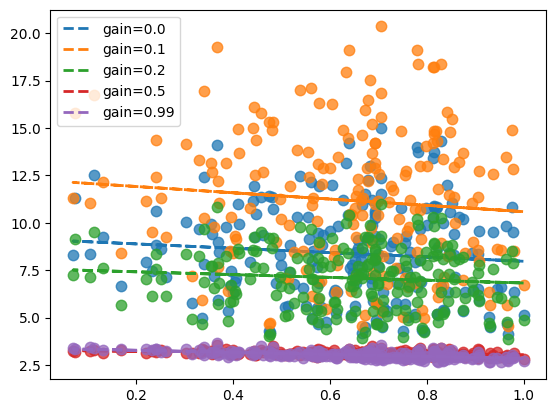

In [43]:
gains2plot = [0, 10, 20, 50, 99]
seed = 7
for g in gains2plot:
    plot, =  plt.plot(RECEPTORS, mean_fr_grid[seed,g], '.', markersize=15, alpha=0.75)
    coeffs = np.polyfit(RECEPTORS, mean_fr_grid[seed,g], 1)
    linear_fit = np.poly1d(coeffs)
    plt.plot(RECEPTORS, linear_fit(RECEPTORS), color=plot.get_color(), label=f'gain={GAINE_range[g]}', linestyle='--', linewidth=2)

plt.legend()
plt.show()